<a href="https://colab.research.google.com/github/Blackbirdf16/Cryptography-/blob/main/qiskit/teleportation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----

# ⚛️ Your First Quantum Teleportation with Qiskit

Welcome\! This notebook is your beginner-friendly guide to understanding and implementing quantum teleportation. We'll break down the theory, explain the Qiskit tools we use, and build the circuit step-by-step.

**What is Quantum Teleportation?**
It's a protocol to transmit a quantum state from one location to another. Imagine Alice wants to send a secret quantum state, $|\psi\rangle$, to Bob. She can't just "copy" it (due to the no-cloning theorem). Instead, she uses a pre-shared pair of entangled qubits and a classical communication channel to help Bob perfectly reconstruct her state.

Crucially, this **does not** transmit matter or energy, and it **cannot** happen faster than light because Alice must send classical information to Bob.

-----

## 1\. Setting Up Your Quantum Workspace

First, we need to install Qiskit and import the necessary tools.

In [ ]:
# Qiskit is the open-source quantum computing software development kit we'll be using.
# The [visualization] part installs extra libraries for drawing circuits and plots.
!pip install qiskit[visualization] qiskit-aer

# Now we import the specific tools we need from the Qiskit library.
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator # Corrected import path for AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector
import numpy as np

print("Qiskit environment is ready! 🚀")

Qiskit environment is ready! 🚀


* * *

## 2\. Understanding Your Qiskit Toolkit 🛠️

Since this is your first time, let's get familiar with the basic Qiskit components we'll be using.

* `QuantumRegister(size, name)`: Think of this as creating a set of quantum "wires". A `QuantumRegister(3, 'q')` gives us three qubits named `q[0]`, `q[1]`, and `q[2]`. We can also create the registers one by one, `QuantumRegister(1, 'Message')` will create only one with with the label Message.
* `ClassicalRegister(size, name)`: This creates classical "wires" to store the results of measurements. A `ClassicalRegister(2, 'c')` gives us two classical bits, `c[0]` and `c[1]`. Again, you can create them one by one.
* `QuantumCircuit(qreg, creg)`: This is our main workspace, our "canvas". We create a circuit and attach our quantum and classical registers to it. All our quantum operations (gates) will be added to this object.
* **Quantum Gates (The Operations):**

  * `circuit.h(qubit_index)`: The **Hadamard gate**. This is a fundamental gate that puts a qubit into a perfect superposition. If you start with $|0\rangle$, an H-gate transforms it into $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$. Think of it as turning a stationary coin into a perfectly spinning one.
  * `circuit.s(qubit_index)`: The **S gate**. This is a phase gate. It leaves the $|0\rangle$ state alone but changes the phase of the $|1\rangle$ state, turning $|1\rangle$ into $i|1\rangle$. It's like rotating the state around the Z-axis on the Bloch sphere 90 degrees.
  * `circuit.cx(control_qubit, target_qubit)`: The **Controlled-NOT (or CNOT) gate**. This is a two-qubit gate and is essential for creating entanglement. It flips the *target* qubit IF AND ONLY IF the *control* qubit is in the state $|1\rangle$.
  * `circuit.x(qubit_index)`: The **X gate**. This is the quantum equivalent of a classical NOT gate. It flips $|0\rangle$ to $|1\rangle$ and $|1\rangle$ to $|0\rangle$.
  * `circuit.z(qubit_index)`: The **Z gate**. This is another phase gate. It leaves $|0\rangle$ alone but flips the phase of $|1\rangle$, turning it into $-|1\rangle$.
* `circuit.barrier()`: This is purely a visual tool. It draws a line in the circuit diagram to help separate different logical sections of the protocol, making it easier to read. It has no effect on the quantum computation itself.
* `circuit.measure(qubit, classical_bit)`: This performs a measurement on a specific qubit and stores the classical outcome (either 0 or 1) in a specified classical bit. This is the bridge from the quantum world to the classical world. You can pass the name of the registers or the position for both the input Qubit and the output classic bit.
* `circuit.if_test((classical_register, value))`: This method allows you to apply quantum gates conditioned on the value of a classical register. The gates within the `with circuit.if_test(...)` block will only be applied if the classical register has the specified value. This is crucial for Bob's recovery step in quantum teleportation, where he applies gates based on Alice's measurement outcomes.

* * *

## 3\. Building the Teleportation Circuit, Step-by-Step

Our circuit will have three characters:

* `m`: **Alice's message qubit**, which holds the state $|\psi\rangle$ we want to teleport. The index of this qubit will be `0` as it is the first register in the call to `QuantumCircuit`.
* `alice`: **Alice's half** of an entangled pair. Its index will be `1`.
* `bob`: **Bob's half** of the entangled pair. Its index will be `2`.

In [ ]:
# Create the quantum and classical registers with names.
# We need 3 qubits: one for the message, one for Alice's entangled qubit, and one for Bob's entangled qubit.
m = QuantumRegister(1, name="Message")
alice = QuantumRegister(1, name="AliceEntangled")
bob = QuantumRegister(1, name="BobEntangled")

# We need 2 classical bits to store Alice's measurement results.
crz = ClassicalRegister(1, name="crz")
crx = ClassicalRegister(1, name="crx")

# Create the quantum circuit and attach the registers.
circuit = QuantumCircuit(m, alice, bob, crz, crx)

### Step B: Create Entanglement (The Shared Channel)

Now, we create a special connection—an entangled Bell pair—between Alice's half of the entangled pair (`alice`) and Bob's qubit (`bob`). This is the resource that makes teleportation possible.

In [ ]:
# --- Part 1: Create a Bell pair between AliceEntangled and BobEntangled ---
circuit.h(alice)       # Put Alice's qubit into superposition.
circuit.cx(alice, bob) # Entangle AliceEntangled and BobEntangled with a CNOT gate.
circuit.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(1, "Message"), index=0>, <Qubit register=(1, "AliceEntangled"), index=0>, <Qubit register=(1, "BobEntangled"), index=0>), clbits=())

### Step C: Create the Quantum State to Teleport (Alice's Message)

Alice needs a quantum state to send. Let's create an arbitrary state on her message qubit (`m`). We'll create the state $|\psi\rangle = \frac{1}{\sqrt{2}}(|0\rangle + i|1\rangle)$. We do this by applying a Hadamard gate, then an S gate.

--- Initial State to Teleport (on Message qubit) ---


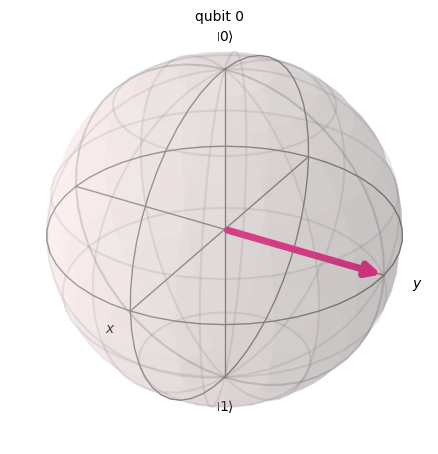

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(1, "Message"), index=0>, <Qubit register=(1, "AliceEntangled"), index=0>, <Qubit register=(1, "BobEntangled"), index=0>), clbits=())

In [ ]:
# --- Part 2: Prepare Alice's message state on q[0] ---
# You can change these gates to create any state you want to teleport!
circuit.h(m)
circuit.s(m) # An S-gate adds a phase of 'i' to the |1> component

# Let's visualize this initial state. It's what we hope Bob receives.
# We create a temporary circuit with just these gates to see the state.
temp_circuit = QuantumCircuit(1)
temp_circuit.h(0)
temp_circuit.s(0)
initial_state = Statevector.from_instruction(temp_circuit)

print("--- Initial State to Teleport (on Message qubit) ---")
# plot_bloch_multivector shows the state of each qubit on a sphere.
# The arrow points to the state's position.
display(plot_bloch_multivector(initial_state))

# Use a barrier to visually separate this step in the circuit diagram.
circuit.barrier()

### Step D: Alice's Operations

Alice now performs operations that link her message qubit (`m`) with her half of the entangled pair (`alice`).

In [ ]:
# --- Part 3: Alice entangles her message qubit with her entangled qubit ---
circuit.cx(m, alice) # CNOT with message as control and her entangled qubit as target.
circuit.h(m)       # Apply a Hadamard gate to the message qubit.
circuit.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(1, "Message"), index=0>, <Qubit register=(1, "AliceEntangled"), index=0>, <Qubit register=(1, "BobEntangled"), index=0>), clbits=())

### Step E: Alice's Measurement

Alice measures her two qubits (`m` and `alice`) and gets two classical bits of information. This is what she will send to Bob.

In [ ]:
# --- Part 4: Alice measures her two qubits ---
# The result from the Message qubit goes into the classical bit 'crz'.
# The result from the AliceEntangled qubit goes into the classical bit 'crx'.
circuit.measure(m, crz)
circuit.measure(alice, crx)
circuit.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(1, "Message"), index=0>, <Qubit register=(1, "AliceEntangled"), index=0>, <Qubit register=(1, "BobEntangled"), index=0>), clbits=())

### Step F: Bob's Recovery

Bob receives the two classical bits from Alice. Based on their values, he applies correction gates to *his* qubit (`bob`) to recover Alice's original state.

  * If Alice's second bit (`crx`) is 1, Bob applies an **X-gate**.
  * If Alice's first bit (`crz`) is 1, Bob applies a **Z-gate**.

Qiskit lets us make these operations conditional using `.if_test()`.

In [ ]:
# --- Part 5: Bob applies conditional gates based on Alice's classical message ---

with circuit.if_test((crx, 1)):
    circuit.x(bob)
with circuit.if_test((crz, 1)):
    circuit.z(bob)

-----

## 4\. Visualizing the Full Circuit

Let's see what our completed teleportation circuit looks like\!


--- Full Quantum Teleportation Circuit ---


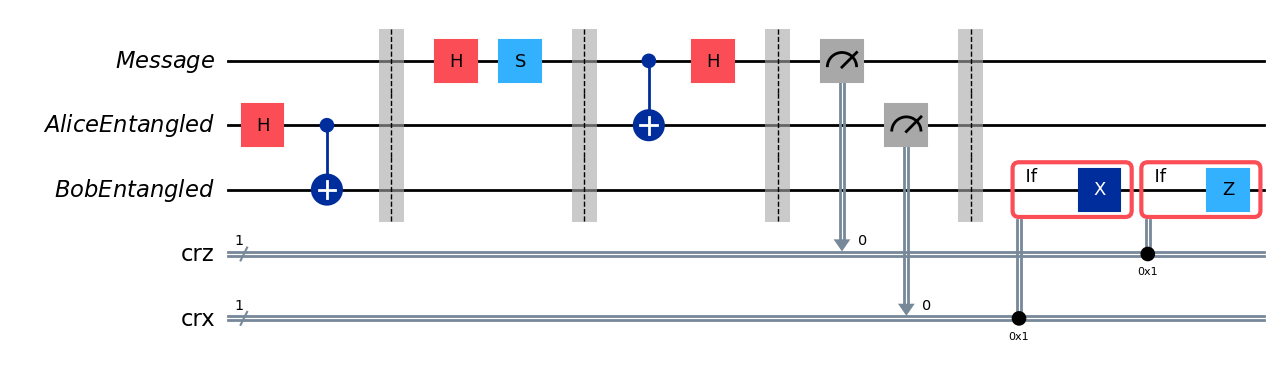

In [ ]:
# The .draw('mpl') function gives us a nice-looking diagram.
print("\n--- Full Quantum Teleportation Circuit ---")
display(circuit.draw('mpl'))

-----

## 5\. Simulation and Verifying the Results ✅

The protocol is built\! Now, we'll use Qiskit's simulator to run the circuit and see if it worked. We'll check if the final state of Bob's qubit (`bob`) matches the initial state of Alice's message qubit (`m`).


--- Final State of All Qubits ---


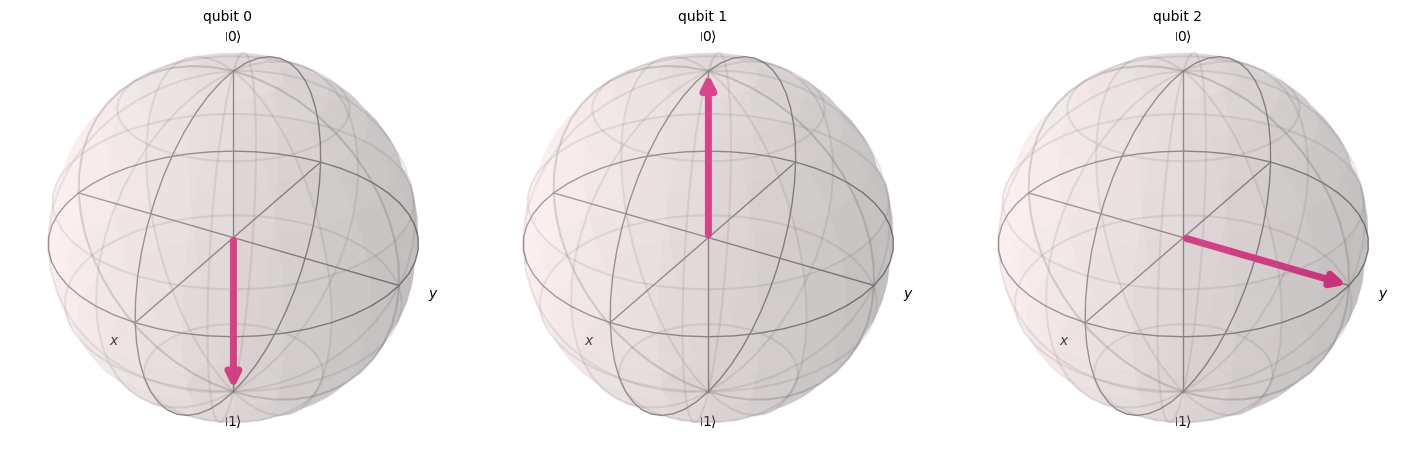


🎉 Teleportation successful! Compare the Bloch sphere for Bob's qubit (q_2, right) with the initial state of Alice's message qubit. They should be identical.


In [ ]:
# We'll use the 'aer_simulator', which is a powerful classical simulator for quantum circuits.
simulator = AerSimulator() # Updated to use AerSimulator

# We want to inspect the final quantum state of all qubits.
# The save_statevector() instruction tells the simulator to save it for us.
circuit.save_statevector()

# The run() function is how you run your circuit in the simulator.
# .result() waits for the job to finish and gets the results.
result = simulator.run(circuit).result()
final_statevector = result.get_statevector()

# Now, let's plot the final state of all three qubits.
print("\n--- Final State of All Qubits ---")
display(plot_bloch_multivector(final_statevector))

print("\n🎉 Teleportation successful! Compare the Bloch sphere for Bob's qubit (right) with the initial state of Alice's message qubit. They should be identical.")

**How to Interpret the Result:**

Look at the Bloch sphere for `qubit 2`, we call it `bob`in our code, in the final plot. It should be identical to the "Initial State" Bloch sphere we plotted for `qubit 0`, we call it `m` in our code, at the very beginning. The states of `qubit 0` and `qubit 1` will be random because they have been measured and collapsed. The fact that `qubit 2` is now in the original state proves that the teleportation was a success\!

-----

## Complete Code for Your Notebook

Here is the entire code in a single block for easy execution in your Colab notebook.

Qiskit is ready to use! 🚀


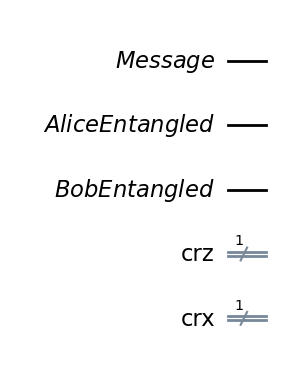

--- Initial State to Teleport (on Message qubit) ---


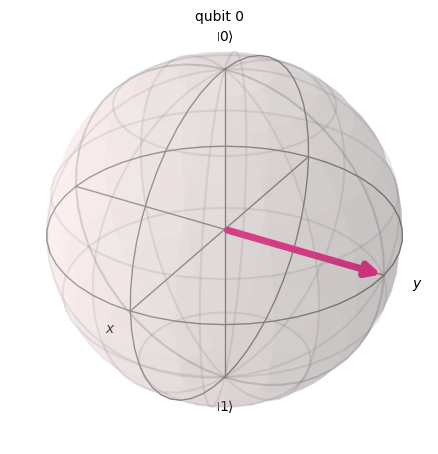


--- Full Quantum Teleportation Circuit ---


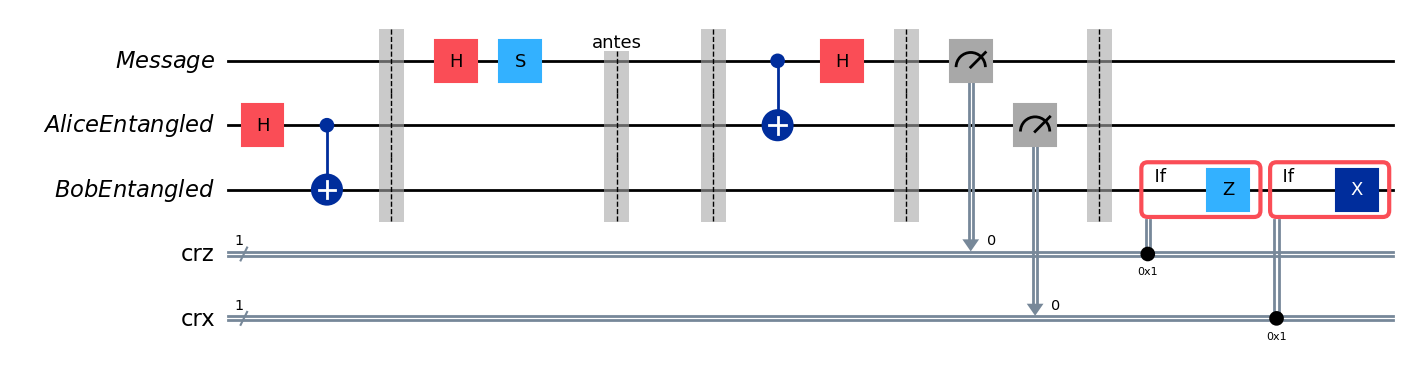


--- Final State of All Qubits (Bob's qubit should match initial message qubit) ---


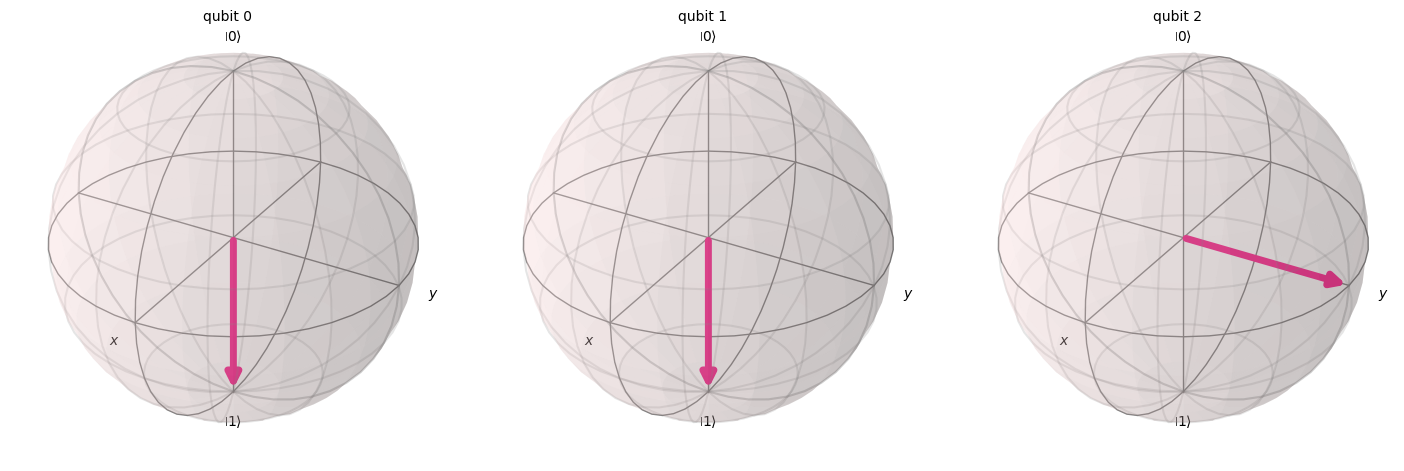


✅ Teleportation complete! The final state of Bob's qubit (BobEntangled, right) now matches the original state of Alice's message qubit.


In [ ]:
# =======================================================
# == QUANTUM TELEPORTATION WITH QISKIT - COMPLETE CODE ==
# =======================================================

# 1. SETUP
# -------------------------------------------------------
# Install Qiskit if it's not already installed in the environment.
try:
    import qiskit
except ImportError:
    print("Installing Qiskit...")
    !pip install qiskit[visualization] qiskit-aer # Added qiskit-aer
    print("Qiskit installed successfully.")

# Import necessary components from the Qiskit library.
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator # Corrected import path for AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector
import numpy as np

print("Qiskit is ready to use! 🚀")


# 2. CIRCUIT CONSTRUCTION
# -------------------------------------------------------
# Create the quantum and classical registers with names.
m = QuantumRegister(1, name="Message")
alice = QuantumRegister(1, name="AliceEntangled")
bob = QuantumRegister(1, name="BobEntangled")
# A ClassicalRegister holds the results of measurements. We need 2.
crz = ClassicalRegister(1, name="crz")
crx = ClassicalRegister(1, name="crx")
# A QuantumCircuit is the blueprint for our quantum program.
circuit = QuantumCircuit(m,alice,bob, crz, crx)

display(circuit.draw('mpl'))


# --- Step A: Create a Bell pair between AliceEntangled and BobEntangled ---
# This entangled pair is the "quantum channel".
circuit.h(alice)
circuit.cx(alice, bob)  # CNOT creates entanglement.
circuit.barrier()


# --- Step B: Prepare Alice's message state on m ---
# This is the secret state Alice wants to send.
# Here, we create the state |+i> = 1/sqrt(2) * (|0> + i|1>).
circuit.h(m)  # Hadamard gate for superposition.
circuit.s(m)  # S-gate for adding a phase.

circuit.save_statevector(label=f'antes')

# Let's visualize the initial state we want to teleport.
# This helps us verify the result at the end.
temp_circuit = QuantumCircuit(1)
temp_circuit.h(0)
temp_circuit.s(0)
initial_state = Statevector.from_instruction(temp_circuit)
print("--- Initial State to Teleport (on Message qubit) ---")
display(plot_bloch_multivector(initial_state))

# Use a barrier to visually separate logical parts of the circuit.
circuit.barrier()

# --- Step C: Alice performs operations linking her message and entangled qubits ---
circuit.cx(m, alice)
circuit.h(m)
circuit.barrier()


# --- Step D: Alice measures her two qubits ---
# The outcomes (0 or 1) are stored in classical bits.
# This information must be sent to Bob classically (e.g., via email).
circuit.measure(m, crz)
circuit.measure(alice, crx)
circuit.barrier()


# --- Step E: Bob applies recovery gates to his qubit (bob) ---
# These operations are CONDITIONAL on the classical bits he received.
with circuit.if_test((crz, 1)):
    circuit.z(bob)
with circuit.if_test((crx, 1)):
    circuit.x(bob)

# 3. VISUALIZATION OF THE FULL CIRCUIT
# -------------------------------------------------------
print("\n--- Full Quantum Teleportation Circuit ---")
display(circuit.draw('mpl'))


# 4. SIMULATION AND VERIFICATION
# -------------------------------------------------------
# Get the ideal quantum simulator from Qiskit's Aer provider.
simulator = AerSimulator() # Updated to use AerSimulator

# Tell the simulator to save the final quantum state of all qubits.
circuit.save_statevector()

# Run the circuit on the simulator and wait for the result.
result = simulator.run(circuit).result()
final_statevector = result.get_statevector()


# Plot the final state of all qubits on Bloch spheres.
print("\n--- Final State of All Qubits (Bob's qubit should match initial message qubit) ---")
display(plot_bloch_multivector(final_statevector))

print("\n✅ Teleportation complete! The final state of Bob's qubit (BobEntangled, right) now matches the original state of Alice's message qubit.")